# Crash Catcher: DashCam Accident Detector  </br>
### Determining whether dashboard camera video contains an accident</br></br>
I use a hierchical recurrent neural network implementation, trained on a set of videos with and without accidents, to determine whether a new video contains an accident or not.</br></br></br> 

</br>

Load in necessary packages

In [60]:
## we want any plots to show up in the notebook
%matplotlib inline
## has the usual packages I use
%run startup
import numpy
import os
import re
import pickle
import timeit
import glob
import cv2

import random
import matplotlib
from array import array
import sys


from skimage import transform
import skimage
from skimage import io

import sklearn
from sklearn.model_selection import train_test_split   ### import sklearn tool

import keras
from keras.preprocessing import image as image_utils
from keras.callbacks import ModelCheckpoint

matplotlib.rcdefaults()  ### set the defaults
matplotlib.rc('font',family='Bitstream Vera Serif')   ### I like my plots to look a certain way :)

ERROR:root:File `'startup.py'` not found.


In [61]:
### here is the function to load in a video from file for analysis

def load_set(videofile):
    '''The input is the path to the video file - the training videos are 99 frames long and have resolution of 720x1248
       This will be used for each video, individially, to turn the video into a sequence/stack of frames as arrays
       The shape returned (img) will be 99 (frames per video), 144 (pixels per column), 256 (pixels per row))
    '''
    ### below, the video is loaded in using VideoCapture function
    vidcap = cv2.VideoCapture(videofile)
    ### now, read in the first frame
    success,image = vidcap.read()
    count = 0       ### start a counter at zero
    success = True  ### start "sucess" flag at True

    img = []        ### create an array to save each image as an array as its loaded 
    while success:  ### e.g.: while success == True
        success, image = vidcap.read()  ### if success is still true, attempt to read in next frame from vidcap video import
        ### read in only if there is an image 
        ### (this won't be true at the end of the video, but we don't want to save an empty image)
        if success:
            image = cv2.resize(image,(256,144))   ### resize to 144,256
            image = skimage.color.rgb2gray(image)   ### convert to grayscale
            #image = skimage.transform.downscale_local_mean(image, (5,5))   ### downsample the image to be a bit more usable
            #print shape(image)   ### old print check
            img.append(image)     ### save processed image to video stack
        count += 1    ### increase count, and repeat
    if(numpy.shape(img)[0]>99):
        img=img[-99:]
        print (numpy.shape(img))
        return img ## return stack of processed, time-dependent images from video
    elif(numpy.shape(img)[0]<99):    
        ### add extra frames or Zero frames
        shape=(144,256)
        zeroFrame=numpy.zeros(shape)
        while(numpy.shape(img)[0]<99):
            img.append(zeroFrame)
        print (numpy.shape(img))    
        return img
    elif(numpy.shape(img)[0]==99):
        print (numpy.shape(img))
        return img

In [62]:
img_filepath = 'D:/Workspace/__Workstation/4th year project/CrashCatcher-master/My work/' #### the filepath for the training video set
neg_all = glob.glob(img_filepath + 'Negative/*.mp4')               #### negative examples 
pos_all = glob.glob(img_filepath + 'Positive/*.mp4')                 #### positive examples

all_files = numpy.concatenate((pos_all, neg_all))
print (len(neg_all), len(pos_all))                                   #### print check

100 100


In [63]:
def label_matrix(values):
    '''transforms labels for videos to one-hot encoding/dummy variables'''
    n_values = numpy.max(values) + 1    ### take max value (that would be 1, because it is a binary classification), 
                                        ### and create n+1 (that would be two) sized matrix
    return numpy.eye(n_values)[values]  ### return matrix with results coded ... '1' in first column for no-accident, '1' in second for accident

labels = numpy.concatenate(([1]*len(pos_all), [0]*len(neg_all[0:len(pos_all)])))  ### create the labels for the videos
labels = label_matrix(labels)           ### make the labels into a matrix for the HRNN training

In [64]:
def make_dataset(rand):
    seq1 = numpy.zeros((len(rand), 99, 144, 256))   ### create an empty array to take in the data
    for i,fi in enumerate(rand):                    ### for each file...
        print (i, fi)                               ### as we go through, print out each one
        if fi[-4:] == '.mp4':
            t = load_set(fi)                        ### load in the video file using previously defined function if .mp4 file
        elif fi[-4:]=='.pkl':
            t = pickle.load(open(fi, 'rb'))         ### otherwise, if it's pickled data, load the pickle
        if numpy.shape(t)==(99,144,256):                  ### double check to make sure the shape is correct, and accept
            seq1[i] = t                             ### save image stack to array
        else:# TypeError:
            print ('ERROR')
            #'Image has shape ', numpy.shape(t), 'but needs to be shape', numpy.shape(seq1[0]) ### if exception is raised, explain
            pass                                    ### continue loading data
    print (numpy.shape(seq1))
    return seq1

In [65]:
##### split data into training and validation (sets and shuffle)ii
x_train, x_t1, y_train, y_t1 = train_test_split(all_files, labels, test_size=0.30, random_state=0)  ### split
x_train = numpy.asarray(x_train); y_train = numpy.asarray(y_train)                          ### need to be arrays

x_testA = numpy.asarray(x_t1[int(len(x_t1)/2):])
y_testA = numpy.asarray(y_t1[int(len(y_t1)/2):])    #### test set

### valid set for model
x_testB = numpy.asarray(x_t1[:int(len(x_t1)/2)])
y_testB = numpy.asarray(y_t1[:int(len(y_t1)/2)])    ### need to be arrays
x_test = make_dataset(x_testB)
y_test=y_testB


0 D:/Workspace/__Workstation/4th year project/CrashCatcher-master/My work/Positive\vehicle_guardrail_019.mp4
(99, 144, 256)
1 D:/Workspace/__Workstation/4th year project/CrashCatcher-master/My work/Negative\NoAccident_071.mp4
(99, 144, 256)
2 D:/Workspace/__Workstation/4th year project/CrashCatcher-master/My work/Negative\NoAccident_008.mp4
(99, 144, 256)
3 D:/Workspace/__Workstation/4th year project/CrashCatcher-master/My work/Positive\vehicle_vehicle_099.mp4
(99, 144, 256)
4 D:/Workspace/__Workstation/4th year project/CrashCatcher-master/My work/Negative\NoAccident_078.mp4
(99, 144, 256)
5 D:/Workspace/__Workstation/4th year project/CrashCatcher-master/My work/Negative\NoAccident_083.mp4
(99, 144, 256)
6 D:/Workspace/__Workstation/4th year project/CrashCatcher-master/My work/Positive\vehicle_guardrail_006.mp4
(99, 144, 256)
7 D:/Workspace/__Workstation/4th year project/CrashCatcher-master/My work/Negative\NoAccident_047.mp4
(99, 144, 256)
8 D:/Workspace/__Workstation/4th year project

In [46]:
#### populate data as random numbers as a sanity check
#seq3 = zeros((60,99,144,256))
#for j in range(60):   ### for each file...
#    [np.random.random((244,256)) for i in range(99)]    ### save image stack to array
#print (shape(seq3))              ### print check

#x_train2, x_test2, y_train2, y_test2 = train_test_split(seq3, labels, test_size=0.2, random_state=0)  ### split
#x_train2 = array(x_train2); y_train2 = array(y_train2)     ### need to be arrays
#x_test2 = array(x_test2); y_test2 = array(y_test2)         ### need to be arrays

In [ ]:
### the code is largely appropriated from the following resource
### https://github.com/fchollet/keras/blob/master/examples/mnist_hierarchical_rnn.py

"""HRNNs can learn across multiple levels of temporal hiearchy over a complex sequence.
Usually, the first recurrent layer of an HRNN encodes a time-dependent video (e.g. set of images)
into a vector. The second recurrent layer then encodes those vectors (encoded by the first layer) into a second layer.
# References
    - [A Hierarchical Neural Autoencoder for Paragraphs and Documents](https://arxiv.org/abs/1506.01057)
    - [Hierarchical recurrent neural network for skeleton based action recognition](http://ieeexplore.ieee.org/stamp/stamp.jsp?tp=&arnumber=7298714)
The first LSTM layer first encodes every column of pixels of shape (240, 1) to a column vector of shape (128,).
The second LSTM layer encodes then these 240 column vectors of shape (240, 128) to a image vector representing the whole image. 
A final Dense layer is added for prediction.
"""
import keras
from keras.models import Model
from keras.layers import Input, Dense, TimeDistributed
from keras.layers import LSTM

### set hyper-parameters
batch_size = 15
num_classes = 2
epochs = 30

### number of hidden layers in each NN
row_hidden = 128
col_hidden = 128

### print basic info
print ('x_train shape: '+ str(x_train.shape))
print (str(x_train.shape[0])+ ' train samples')
print (str(x_test.shape[0])+ ' test samples')

### get shape of rows/columns for each image
frame, row, col = (99, 144, 256)

### 4D input - for each 3-D sequence (of 2-D image) in each video (4th)
x = Input(shape=(frame, row, col))

encoded_rows = TimeDistributed(LSTM(row_hidden))(x)  ### encodes row of pixels using TimeDistributed Wrapper
encoded_columns = LSTM(col_hidden)(encoded_rows)     ### encodes columns of encoded rows using previous layer

### set up prediction and compile the model
prediction = Dense(num_classes, activation='softmax')(encoded_columns)
model = Model(x, prediction)
model.compile(loss='categorical_crossentropy', ### loss choice for category classification - computes probability error
              optimizer='NAdam',               ### NAdam optimization
              metrics=['accuracy'])            ### grade on accuracy during each epoch/pass

### create a filepath to save best results as we go - http://machinelearningmastery.com/check-point-deep-learning-models-keras/
### because who wants to train this crazy stuff more than once??!
i=0; filepath='HRNN_Model_200Videos.hdf5'
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]


### now we actually train - because of my laptop memory issues, this means the training data cannot
### be loaded into memory all at once because python will crash. To get around this issue, we load in 
### the whole dataset and loop through in batches of 15. 
### However, each time we pass through the entire dataset, the order of the data needs to be randomized.
### So, we shuffle the list of files during each epoch, then split into batches of 15 videos
numpy.random.seed(18247)  ### set a random seed for repeatability

for i in range(0, 30):               ### number of epochs
    print('*'+str(i)+'/30******************************************')
    c = list(zip(x_train, y_train))  ### bind the features and labels together
    random.shuffle(c)                ### shuffle the list
    x_shuff, y_shuff = zip(*c)       ### unzip list into shuffled features and labels
    x_shuff = numpy.asarray(x_shuff)
    y_shuff= numpy.asarray(y_shuff) ### back into arrays
    
    x_batch = [x_shuff[i:i + batch_size] for i in range(0, len(x_shuff), batch_size)] ### make features into batches of 15
    y_batch = [y_shuff[i:i + batch_size] for i in range(0, len(x_shuff), batch_size)] ### make labels into batches of 15

    for j,xb in enumerate(x_batch):  ### for each batch in the shuffled list for this epoch
        xx = make_dataset(xb)        ### load the feature data into arrays
        yy = y_batch[j]              ### set the labels for the batch
        
        model.fit(xx, yy,                            ### fit training data
                  batch_size=len(xx),                ### reiterate batch size - in this case we already set up the batches
                  epochs=1,                          ### number of times to run through each batch
                  validation_data=(x_test, y_test),  ### validation set from up earlier in notebook
                  callbacks=callbacks_list)          ### save if better than previous!

# evaluate
scores = model.evaluate(x_test, y_test, verbose=0)    ### score model
print('Test loss:', scores[0])                        ### test loss
print('Test accuracy:', scores[1])                    ### test accuracy (ROC later)

In [72]:
### first, load and compile the saved model to make predictions
model.load_weights("HRNN_Model_200Videos.hdf5")
model.compile(loss='binary_crossentropy', optimizer='Nadam', metrics=['accuracy'])

### make the holdout test dataset for prediction and comparison
x_holdout = make_dataset(x_testA)

0 D:/Workspace/__Workstation/4th year project/CrashCatcher-master/My work/Positive\vehicle_guardrail_017.mp4
(99, 144, 256)
1 D:/Workspace/__Workstation/4th year project/CrashCatcher-master/My work/Positive\vehicle_vehicle_056.mp4
(99, 144, 256)
2 D:/Workspace/__Workstation/4th year project/CrashCatcher-master/My work/Negative\NoAccident_051.mp4
(99, 144, 256)
3 D:/Workspace/__Workstation/4th year project/CrashCatcher-master/My work/Negative\NoAccident_012.mp4
(99, 144, 256)
4 D:/Workspace/__Workstation/4th year project/CrashCatcher-master/My work/Positive\vehicle_vehicle_023.mp4
(99, 144, 256)
5 D:/Workspace/__Workstation/4th year project/CrashCatcher-master/My work/Negative\NoAccident_090.mp4
(99, 144, 256)
6 D:/Workspace/__Workstation/4th year project/CrashCatcher-master/My work/Negative\NoAccident_030.mp4
(99, 144, 256)
7 D:/Workspace/__Workstation/4th year project/CrashCatcher-master/My work/Positive\vehicle_guardrail_005.mp4
(99, 144, 256)
8 D:/Workspace/__Workstation/4th year pr

0 D:/Workspace/__Workstation/4th year project/CrashCatcher-master/My work/Negative\NoAccident_032.mp4
(99, 144, 256)
(1, 99, 144, 256)
0 D:/Workspace/__Workstation/4th year project/CrashCatcher-master/My work/Positive\vehicle_vehicle_097.mp4
(99, 144, 256)
(1, 99, 144, 256)
0 D:/Workspace/__Workstation/4th year project/CrashCatcher-master/My work/Negative\NoAccident_082.mp4
(99, 144, 256)
(1, 99, 144, 256)
0 D:/Workspace/__Workstation/4th year project/CrashCatcher-master/My work/Positive\vehicle_guardrail_020.mp4
(99, 144, 256)
(1, 99, 144, 256)
0 D:/Workspace/__Workstation/4th year project/CrashCatcher-master/My work/Negative\NoAccident_054.mp4
(99, 144, 256)
(1, 99, 144, 256)
0 D:/Workspace/__Workstation/4th year project/CrashCatcher-master/My work/Positive\vehicle_vehicle_093.mp4
(99, 144, 256)
(1, 99, 144, 256)
0 D:/Workspace/__Workstation/4th year project/CrashCatcher-master/My work/Positive\vehicle_vehicle_055.mp4
(99, 144, 256)
(1, 99, 144, 256)
0 D:/Workspace/__Workstation/4th 

(99, 144, 256)
(1, 99, 144, 256)
0 D:/Workspace/__Workstation/4th year project/CrashCatcher-master/My work/Positive\vehicle_guardrail_016.mp4
(99, 144, 256)
(1, 99, 144, 256)
0 D:/Workspace/__Workstation/4th year project/CrashCatcher-master/My work/Positive\vehicle_vehicle_079.mp4
(99, 144, 256)
(1, 99, 144, 256)
0 D:/Workspace/__Workstation/4th year project/CrashCatcher-master/My work/Negative\NoAccident_005.mp4
(99, 144, 256)
(1, 99, 144, 256)
0 D:/Workspace/__Workstation/4th year project/CrashCatcher-master/My work/Positive\vehicle_vehicle_053.mp4
(99, 144, 256)
(1, 99, 144, 256)
0 D:/Workspace/__Workstation/4th year project/CrashCatcher-master/My work/Negative\NoAccident_001.mp4
(99, 144, 256)
(1, 99, 144, 256)
0 D:/Workspace/__Workstation/4th year project/CrashCatcher-master/My work/Positive\vehicle_vehicle_077.mp4
(99, 144, 256)
(1, 99, 144, 256)
0 D:/Workspace/__Workstation/4th year project/CrashCatcher-master/My work/Positive\vehicle_guardrail_004.mp4
(99, 144, 256)
(1, 99, 144

(99, 144, 256)
(1, 99, 144, 256)
0 D:/Workspace/__Workstation/4th year project/CrashCatcher-master/My work/Negative\NoAccident_066.mp4
(99, 144, 256)
(1, 99, 144, 256)
0 D:/Workspace/__Workstation/4th year project/CrashCatcher-master/My work/Positive\vehicle_vehicle_082.mp4
(99, 144, 256)
(1, 99, 144, 256)
0 D:/Workspace/__Workstation/4th year project/CrashCatcher-master/My work/Negative\NoAccident_089.mp4
(99, 144, 256)
(1, 99, 144, 256)
0 D:/Workspace/__Workstation/4th year project/CrashCatcher-master/My work/Negative\NoAccident_075.mp4
(99, 144, 256)
(1, 99, 144, 256)
0 D:/Workspace/__Workstation/4th year project/CrashCatcher-master/My work/Negative\NoAccident_091.mp4
(99, 144, 256)
(1, 99, 144, 256)
0 D:/Workspace/__Workstation/4th year project/CrashCatcher-master/My work/Positive\vehicle_vehicle_040.mp4
(99, 144, 256)
(1, 99, 144, 256)
0 D:/Workspace/__Workstation/4th year project/CrashCatcher-master/My work/Positive\Vehicle_vehicle_059.mp4
(99, 144, 256)
(1, 99, 144, 256)
0 D:/Wo

(99, 144, 256)
14 D:/Workspace/__Workstation/4th year project/CrashCatcher-master/My work/Negative\NoAccident_069.mp4
(99, 144, 256)
15 D:/Workspace/__Workstation/4th year project/CrashCatcher-master/My work/Positive\vehicle_vehicle_064.mp4
(99, 144, 256)
16 D:/Workspace/__Workstation/4th year project/CrashCatcher-master/My work/Positive\vehicle_guardrail_009.mp4
(99, 144, 256)
17 D:/Workspace/__Workstation/4th year project/CrashCatcher-master/My work/Positive\vehicle_vehicle_076.mp4
(99, 144, 256)
18 D:/Workspace/__Workstation/4th year project/CrashCatcher-master/My work/Negative\NoAccident_019.mp4
(99, 144, 256)
19 D:/Workspace/__Workstation/4th year project/CrashCatcher-master/My work/Negative\NoAccident_044.mp4
(99, 144, 256)
20 D:/Workspace/__Workstation/4th year project/CrashCatcher-master/My work/Positive\vehicle_vehicle_072.mp4
(99, 144, 256)
21 D:/Workspace/__Workstation/4th year project/CrashCatcher-master/My work/Negative\NoAccident_025.mp4
(99, 144, 256)
22 D:/Workspace/__W

C:\Python36\lib\site-packages\matplotlib\font_manager.py:1316: UserWarning: findfont: Font family ['Bitstream Vera Serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


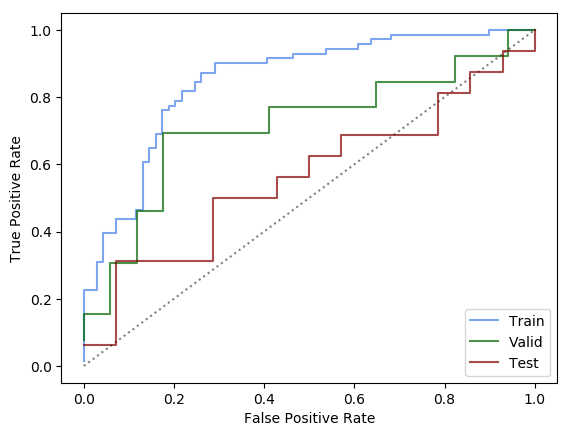

In [73]:
matplotlib.pyplot.plot([0,1],[0,1],'k:',alpha=0.5)                       ### plot the "by chance" line - the goal is to achieve better than random accuracy
ys = [y_train, y_testB, y_testA]                       ### set up labels to be iterated through
labs = ['Train', 'Valid', 'Test']                      ### set up tags to be iterated through
col = ['#4881ea', 'darkgreen', 'maroon']               ### set up colors to be iterated through
preds = []                                             ### set up prediction as empty array to populate
for i,xset in enumerate([x_train, x_testB, x_testA]):  ### iterate through each set of data
    if i==0:
        new_pred = []                                  ### for first dataset, need to iterate through each
        for k in xset:                                 ### to save memory (because we can't load the whole
            d = make_dataset([k])                      ### thing at once)
            new_pred.append(model.predict(d))          ### predictions with loaded model for each in training set
        new_pred = numpy.asarray(new_pred).reshape((len(new_pred),2))
    else:
        d = make_dataset(xset)                         ### can load all of valid/test datasets at once in memory
        new_pred = model.predict(d)                    ### predictions with loaded model for each valid/test dataset
    preds.append(new_pred)
    fpr, tpr, threshs = sklearn.metrics.roc_curve(ys[i][:,1], new_pred[:,1]) ### get the false pos rate and true pos rate
    matplotlib.pyplot.plot(fpr, tpr, '-', color=col[i], alpha=0.7, lw=1.5, label=labs[i])      ### plot the ROC curve with false pos rate and true pos rate
    
    print (labs[i])
    print (sklearn.metrics.auc(fpr, tpr))             ### print area under curve for each set
    print (sklearn.metrics.accuracy_score(ys[i][:,1], [round(j) for j in new_pred[:,1]]))   ### print accuracy for each set
    print (sklearn.metrics.confusion_matrix(ys[i][:,1], [round(j) for j in new_pred[:,1]])) ### print confusion matrix for each
    
matplotlib.pyplot.xlabel('False Positive Rate'); matplotlib.pyplot.ylabel('True Positive Rate')
matplotlib.pyplot.legend(fancybox=True, loc=4, prop={'size':10})
matplotlib.pyplot.show()

C:\Python36\lib\site-packages\matplotlib\font_manager.py:1316: UserWarning: findfont: Font family ['Bitstream Vera Serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


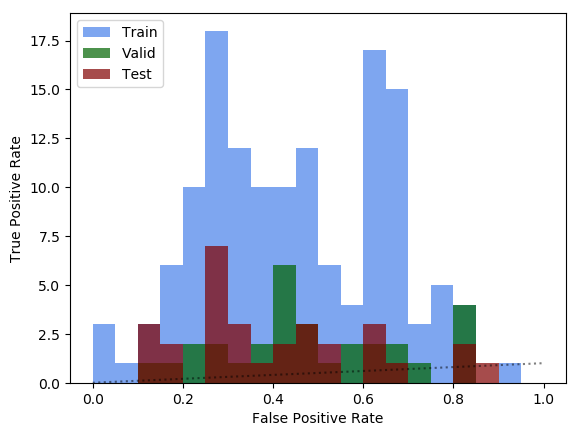

In [74]:
matplotlib.pyplot.plot([0,1],[0,1],'k:',alpha=0.5)                  ### plot the "by chance" line - trying so hard to be better than this...
for i,p in enumerate(preds):                      ### for each of the calculated predictions, make a histogram
    matplotlib.pyplot.hist(p[:,1], bins = numpy.arange(0,1,0.05), histtype='stepfilled', color=col[i], alpha=0.7, label=labs[i])
matplotlib.pyplot.xlabel('False Positive Rate')
matplotlib.pyplot.ylabel('True Positive Rate')
matplotlib.pyplot.legend(fancybox=True, loc=2, prop={'size':10})
matplotlib.pyplot.show()